In [1]:
# Import modules
import osmnx as ox 

import numpy as np
import geopandas as gpd
import pandas as pd

from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import LineString, MultiLineString
# Import module
import networkx as nx
import matplotlib.pyplot as plt

from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
ox.config(log_console=True, use_cache=True)
ox.__version__

'1.1.2'

2022-03-02 15:07:56 Configured OSMnx 1.1.2
2022-03-02 15:07:56 HTTP response caching is on


# limit Vax Data to 3 Counties Comprising Detroit Metro Area

In [2]:
vax_df = pd.read_csv('/Users/zachary/Desktop/WINTER22/Geog490/COVID_VaccineClinics/Covid-19_Vaccination_Provider_Locations_in_the_United_States.csv')

/var/folders/8v/6dq3dnld7rx4qv5wr7vx0w5m0000gn/T/ipykernel_30211/1376959616.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  vax_df = pd.read_csv('/Users/zachary/Desktop/WINTER22/Geog490/COVID_VaccineClinics/Covid-19_Vaccination_Provider_Locations_in_the_United_States.csv')


In [3]:
# Convert DataFrame to GeoDataFrame
vax_gdf = gpd.GeoDataFrame(vax_df, geometry=gpd.points_from_xy(vax_df['X'], vax_df['Y']))

In [4]:
#Reproject to UTM 17
vax_gdf.crs = 'EPSG:32617'

I wonder what it would look like to adapt the following code to each vaccine clinic in Detroit and turn it into walk and driving from the lat lon with the set distance. 

In [5]:
#limit by state to Michigan
vax_MI = vax_gdf[vax_gdf['State']== 'MI'] 

In [6]:
vax_MI['county'].unique()

array(['Alpena', 'Kalamazoo', 'Montmorency', 'Marquette', 'Alcona',
       'Eaton', 'Genesee', 'Macomb', 'Oakland', 'Monroe', 'Saginaw',
       'Wayne', 'Washtenaw', 'Livingston', 'Ingham', 'Kent',
       'Grand Traverse', 'Berrien', 'Muskegon', 'Isabella', 'Emmet',
       'Calhoun', 'Bay', 'Ottawa', 'St. Clair', 'Menominee', 'Van Buren',
       'St. Joseph', 'Jackson', 'Ionia', 'Lenawee', 'Cheboygan',
       'Dickinson', 'Ogemaw', 'Iosco', 'Oscoda', 'Presque Isle',
       'Crawford', 'Kalkaska', 'Lake', 'Manistee', 'Mason', 'Mecosta',
       'Missaukee', 'Newaygo', 'Oceana', 'Wexford', 'Midland', 'Benzie',
       'Clinton', 'Gratiot', 'Montcalm', 'Otsego', 'Branch', 'Lapeer',
       'Antrim', 'Charlevoix', 'Hillsdale', 'Shiawassee', 'Delta',
       'Tuscola', 'Allegan', 'Cass', 'Sanilac', 'Gladwin', 'Osceola',
       'Clare', 'Roscommon', 'Arenac', 'Barry', 'Huron', 'Leelanau', nan],
      dtype=object)

In [7]:
#Limit By County to Wayne, Oakland, and Macomb
vax_wayne = vax_MI[vax_MI['county']== 'Wayne']
vax_oakland = vax_MI[vax_MI['county']== 'Oakland'] 
vax_macomb = vax_MI[vax_MI['county']== 'Macomb']

In [8]:
#Agglomerate to one GDF of Detroit Metro
vax_detr_metro = vax_wayne 
vax_detr_metro = vax_detr_metro.append(vax_oakland)
vax_detr_metro = vax_detr_metro.append(vax_macomb)

/var/folders/8v/6dq3dnld7rx4qv5wr7vx0w5m0000gn/T/ipykernel_30211/951935581.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vax_detr_metro = vax_detr_metro.append(vax_oakland)
/var/folders/8v/6dq3dnld7rx4qv5wr7vx0w5m0000gn/T/ipykernel_30211/951935581.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vax_detr_metro = vax_detr_metro.append(vax_macomb)


In [9]:
vax_detr_metro.head()

,X,Y,OBJECTID,facilityid,name,fulladdr,municipality,agency,agencytype,phone,...,bulk_upload,Same_Day_Results,take_home_test,Wheelchair_Accessible,Accessibility_Support,offers_vaccine,vaccine_url,minimum_age_vaccine,verified_date,geometry
636,-83.480608,42.396377,13143,103,CVS Pharmacy,"44300 5 Mile Road, Northville, MI 48168",Northville,CVS Health,Private,734-416-1883,...,1.0,Yes,No,NaN,Unknown,Yes,https://www.cvs.com/immunizations/covid-19-vac...,NaN,2021/10/13 00:00:00+00,POINT (-83.481 42.396)
802,-82.914795,42.390326,13314,8081,CVS Pharmacy,"17120 Kercheval Avenue, Grosse Pointe, MI 48230",Grosse Pointe,CVS Health,Private,NaN,...,1.0,No,No,NaN,Unknown,Yes,https://www.cvs.com/immunizations/covid-19-vac...,NaN,2021/10/13 00:00:00+00,POINT (-82.915 42.390)
2051,-83.200483,42.430107,17446,8399,CVS Pharmacy,"15521 West Seven Mile Road, Detroit, MI 48235",Detroit,CVS Health,Private,NaN,...,1.0,No,No,NaN,Unknown,Yes,https://www.cvs.com/immunizations/covid-19-vac...,NaN,2021/10/13 00:00:00+00,POINT (-83.200 42.430)
2152,-83.128837,42.331688,17551,8141,CVS Pharmacy,"6862 N. Michigan Ave., Detroit, MI 48209",Detroit,CVS Health,Private,NaN,...,1.0,No,No,NaN,Unknown,Yes,https://www.cvs.com/immunizations/covid-19-vac...,NaN,2021/10/13 00:00:00+00,POINT (-83.129 42.332)
2248,-83.160629,42.432167,19841,NaN,Rite Aid,"19150 Wyoming St Detroit, MI 48221",Detroit,"Rite Aid, Verily, PWN Health & U.S. DHHS",Private,313-341-9700,...,1.0,No,Yes,Unknown,Unknown,Yes,https://www.riteaid.com/pharmacy/covid-qualifier,12.0,2021/07/01 00:00:00+00,POINT (-83.161 42.432)


# OSMNX Isocrhone Maps

In [45]:
# configure the place, network type, trip times, and travel speed
place = vax_detr_metro['Y'].iloc[15],vax_detr_metro['X'].iloc[15]
network_type = 'drive'
trip_times = [5, 10, 15, 20, 25] #in minutes
travel_speed = 48.3 #walking speed in km/hour
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minutee


In [46]:
print (place)

(42.3101716001655, -83.3503022999872)


In [56]:
# download the street network
G = ox.graph_from_point(place, dist = 10000,network_type=network_type)

2022-03-02 15:22:47 Created bbox 10000 m from (42.3101716001655, -83.3503022999872): 42.40010363371479,42.220239566616215,-83.22869226308788,-83.47191233688653
2022-03-02 15:22:47 Projected GeoDataFrame to +proj=utm +zone=17 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-03-02 15:22:47 Projected GeoDataFrame to epsg:4326
2022-03-02 15:22:47 Projected GeoDataFrame to +proj=utm +zone=17 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-03-02 15:22:47 Projected GeoDataFrame to epsg:4326
2022-03-02 15:22:47 Requesting data within polygon from API in 1 request(s)
2022-03-02 15:22:47 Resolved overpass-api.de to 178.63.11.215
2022-03-02 15:22:48 Pausing 0 seconds before making HTTP POST request
2022-03-02 15:22:48 Post https://overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%5Btimeout%3A180%5D%3B%28way%5B%22highway%22%5D%5B%22area%22%21~%22yes%22%5D%5B%22access%22%21~%22private%22%5D%5B%22highway%22%21~%22abandoned%7Cbridleway%7Cbus_guideway%7Cconstruction%7Ccorridor

In [57]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(G, (y[0], x[0]))
G = ox.project_graph(G)

2022-03-02 15:24:02 Created nodes GeoDataFrame from graph
2022-03-02 15:24:02 Created nodes GeoDataFrame from graph


/Users/zachary/opt/anaconda3/envs/final_ML_LR/lib/python3.8/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


2022-03-02 15:24:03 Created nodes GeoDataFrame from graph
2022-03-02 15:24:06 Projected GeoDataFrame to +proj=utm +zone=17 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-03-02 15:24:10 Created edges GeoDataFrame from graph
2022-03-02 15:24:13 Projected GeoDataFrame to +proj=utm +zone=17 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-03-02 15:24:14 Created graph from node/edge GeoDataFrames
2022-03-02 15:24:14 Projected graph with 14588 nodes and 40715 edges


In [58]:
# add an edge attribute for time in minutes required to traverse each edge
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [59]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

2022-03-02 15:24:19 Begin plotting the graph...
2022-03-02 15:24:21 Created edges GeoDataFrame from graph
2022-03-02 15:24:23 Created nodes GeoDataFrame from graph


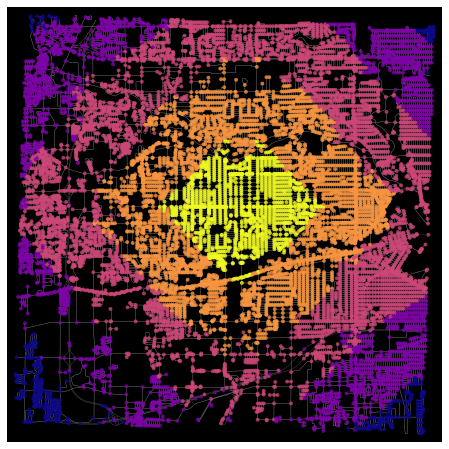

2022-03-02 15:24:27 Finished plotting the graph


In [60]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,
                        bgcolor='k', edge_linewidth=0.2, edge_color='#999999')

In [61]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

2022-03-02 15:24:36 Begin plotting the graph...
2022-03-02 15:24:38 Created edges GeoDataFrame from graph
2022-03-02 15:24:43 Finished plotting the graph


/Users/zachary/opt/anaconda3/envs/final_ML_LR/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


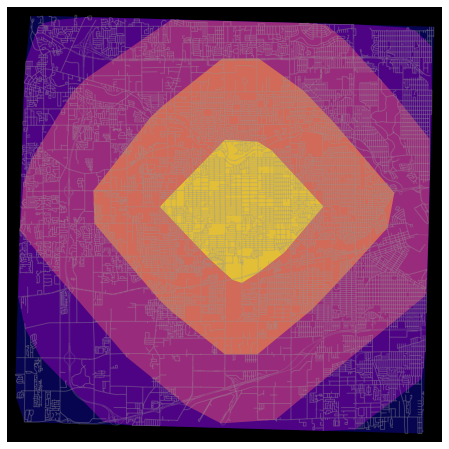

In [62]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='k')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

2022-03-02 15:28:22 Begin plotting the graph...
2022-03-02 15:28:24 Created edges GeoDataFrame from graph


/Users/zachary/opt/anaconda3/envs/final_ML_LR/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


2022-03-02 15:28:29 Finished plotting the graph


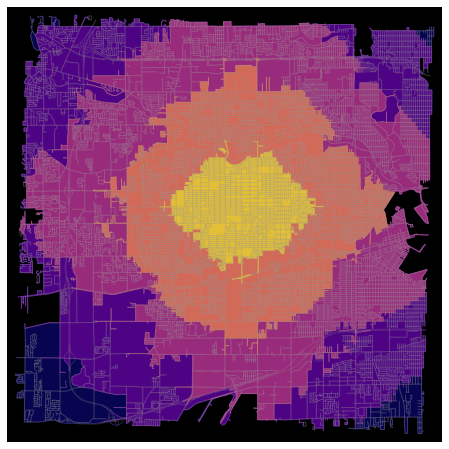

In [63]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='k')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()